In [1]:


# Import stuff
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = "notebook_connected"


import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")



In [63]:
## turn off AD to save memory, since we're focusing on model inference here 
t.set_grad_enabled(False)

device = 'cuda' if t.cuda.is_available() else 'cpu'
model = HookedTransformer.from_pretrained('gpt2-small', device=device)


text1 = "This is my input to gpt2-small"
logits, loss = model(text1, return_type = 'both')

## LG experiment: the loss should decrease with more context
text2 = text1 + "The more context I give it, the lower the loss I will achieve"
text3 = text2 + "Let's see how low we can make it while still only giving it a reasonable number of prompts."
text4 = text3 + "It's still not very low but at least it's going down..."
texts = [text1,text2,text3,text4]
test_losses = [model(text, return_type = 'loss') for text in texts]
print('cross-entropy losses with increasing context: ', test_losses)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer
cross-entropy losses with increasing context:  [tensor(5.6510), tensor(5.1699), tensor(4.5359), tensor(4.2693)]


Not sure why there are 3 copies of blocks.0.ln1.hook_scale and blocks.0.ln1.hook_normalized... ANSWER (from Neel/ slack): ln1 takes data that is split between the three subsequent matrices (Q, K, V), so it appears 3 times.

Understand "folding in" : I want to make sure I understand what's happening when layernorm is folded in. Hopefully this will also help me understand how to access each part of the transformer using hooks/ model.attributes. 

In [48]:

model_attn_only = HookedTransformer.from_pretrained('attn-only-2l', device=device)
model_attn_only_no_fold = HookedTransformer.from_pretrained('attn-only-2l', device=device, fold_ln=False)

print('Reference: Hyperparameters for the model')
dataclasses.asdict(model_attn_only.cfg)

Loaded pretrained model attn-only-2l into HookedTransformer
Loaded pretrained model attn-only-2l into HookedTransformer
Reference: Hyperparameters for the model


{'n_layers': 2,
 'd_model': 512,
 'n_ctx': 1024,
 'd_head': 64,
 'model_name': 'Attn_Only_2L512W_C4_Code',
 'n_heads': 8,
 'd_mlp': 2048,
 'act_fn': 'solu_ln',
 'd_vocab': 48262,
 'eps': 1e-05,
 'use_attn_result': False,
 'use_attn_scale': True,
 'use_split_qkv_input': False,
 'use_local_attn': False,
 'original_architecture': 'neel',
 'from_checkpoint': False,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'tokenizer_name': 'NeelNanda/gpt-neox-tokenizer-digits',
 'window_size': None,
 'attn_types': None,
 'init_mode': 'gpt2',
 'normalization_type': 'LNPre',
 'device': 'cpu',
 'attention_dir': 'causal',
 'attn_only': True,
 'seed': None,
 'initializer_range': 0.035355339059327376,
 'init_weights': False,
 'scale_attn_by_inverse_layer_idx': False,
 'positional_embedding_type': 'standard',
 'final_rms': False,
 'd_vocab_out': 48262,
 'parallel_attn_mlp': False,
 'rotary_dim': None,
 'n_params': 2097152,
 'use_hook_tokens': False}

In [67]:
#test_prompt = "The quick brown fox jumped over the lazy dog"


test_prompt = text4
logits_gpt, cache_gpt = model.run_with_cache(test_prompt)

logits, cache = model_attn_only.run_with_cache(test_prompt)
logits_no_fold, cache_no_fold = model_attn_only_no_fold.run_with_cache(test_prompt)

print(t.all(logits - logits_no_fold < 1e-6))
print('Reference: Hyperparameters for the model')
dataclasses.asdict(model_attn_only.cfg)

tensor(False)
Reference: Hyperparameters for the model


{'n_layers': 2,
 'd_model': 512,
 'n_ctx': 1024,
 'd_head': 64,
 'model_name': 'Attn_Only_2L512W_C4_Code',
 'n_heads': 8,
 'd_mlp': 2048,
 'act_fn': 'solu_ln',
 'd_vocab': 48262,
 'eps': 1e-05,
 'use_attn_result': False,
 'use_attn_scale': True,
 'use_split_qkv_input': False,
 'use_local_attn': False,
 'original_architecture': 'neel',
 'from_checkpoint': False,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'tokenizer_name': 'NeelNanda/gpt-neox-tokenizer-digits',
 'window_size': None,
 'attn_types': None,
 'init_mode': 'gpt2',
 'normalization_type': 'LNPre',
 'device': 'cpu',
 'attention_dir': 'causal',
 'attn_only': True,
 'seed': None,
 'initializer_range': 0.035355339059327376,
 'init_weights': False,
 'scale_attn_by_inverse_layer_idx': False,
 'positional_embedding_type': 'standard',
 'final_rms': False,
 'd_vocab_out': 48262,
 'parallel_attn_mlp': False,
 'rotary_dim': None,
 'n_params': 2097152,
 'use_hook_tokens': False}

In [55]:
eps = 1e-5
test_x_in = cache['blocks.0.hook_resid_pre']
x_norm = cache['blocks.0.ln1.hook_normalized']
denom = t.sqrt(t.var(test_x_in, dim=-1, keepdim=True, unbiased=False) + eps)

assert t.all(test_x_in/denom - x_norm <= 1e-6)
assert t.all((cache['blocks.0.ln1.hook_scale'] - denom) <1e-7)

In [73]:
print(cache.keys())
print(cache['blocks.0.ln1.hook_scale'].shape)
print(cache['blocks.0.ln1.hook_normalized'].shape)

x_norm_nf = cache_no_fold['blocks.0.ln1.hook_normalized']

x_norm = cache['blocks.0.ln1.hook_normalized']

## checking that x_norm is what I think it is 
test_x_in = cache_no_fold['blocks.0.hook_resid_pre']
## input is input in either model 
assert t.all(cache['blocks.0.hook_resid_pre'] == test_x_in)

eps = 1e-5
denom = t.sqrt(t.var(test_x_in, dim=-1, keepdim=True, unbiased=False) + eps)

# ## centering is off for no_fold, but the inputs should be the same once the mean is removed: 

# centered = test_x_in - t.mean(test_x_in, dim=-1, keepdim=True)

# centering is on, so the mean should be 0, or very close
assert t.all(t.mean(test_x_in, dim=-1) <= 1e-8)
assert t.all(test_x_in == cache['blocks.0.hook_resid_pre'])
assert t.all(test_x_in/denom - x_norm <= 1e-6)

## checking that x_norm has mean = 0 and var = 1
assert t.all(t.mean(x_norm, dim=-1) <= 1e-7)
print(t.var(x_norm, dim=-1)) 





dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_post', 'ln_final.hook_scale', 'ln_final.hook_normalized'])
torch.Size([1, 59, 1])
torch.Size([1, 59, 512])
tensor([[1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0017,
         1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0017, 1.0017,
         1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018, 1.0018,
         1.001

In [57]:
t.all(cache['blocks.0.ln1.hook_scale'] == cache_no_fold['blocks.0.ln1.hook_scale'])
## hook scale is just the scale factor in the normalization -- makes sense that it's diagonal, because it's the same for all features 
assert t.all((cache['blocks.0.ln1.hook_scale'] - denom) <1e-7)
#### x_norm_nf = W_{LN} x_norm, where W_{LN} should be folded into the subsequent matrix, even though the hooked matrices don't reflect that (the internals should). But the residual stream after the subsequent layer should be the same... let's check 
assert t.all(x_norm_nf != x_norm)
## good, so when we output the attention residual stream, it's all the same. 
assert t.all((cache['blocks.0.hook_attn_out'] - cache_no_fold['blocks.0.hook_attn_out'])<1e-5)

IMPORTANT: the weight matrices (W_LN, W_Q, etc.) in are THE SAME in the models with and without fold in. THE ONLY THING THAT CHANGES IS THE RESIDUAL STREAM (and hook normalized, which depends on the residual stream)

This means that, to see the differences, we need to look at the residuals. 

In [58]:

# LN weights are the same, one is just incorporated into the next layer
W_LN_nf = cache_no_fold['blocks.0.ln1.hook_scale']
W_LN = cache['blocks.0.ln1.hook_scale']
assert t.all(W_LN_nf == W_LN )


W_Q = cache['blocks.0.attn.hook_q']

W_Q_nf = cache_no_fold['blocks.0.attn.hook_q']
W_eff = (W_LN_nf[:,:,None]*W_Q_nf)
assert W_eff.shape == W_Q_nf.shape


assert t.all(W_Q -  W_Q_nf <= 1e-5)

## should also work via matrix multiplication (my brain likes this way better, but it is more cumbersome)

assert t.all(t.einsum('bsnd, bs -> bsnd',W_Q_nf,W_LN_nf.squeeze(-1)) == W_eff)



Is the distribution of the layer norm scale factor bimodal? 

In [59]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_post', 'ln_final.hook_scale', 'ln_final.hook_normalized']

Text(0.5, 0, 'scale factor')

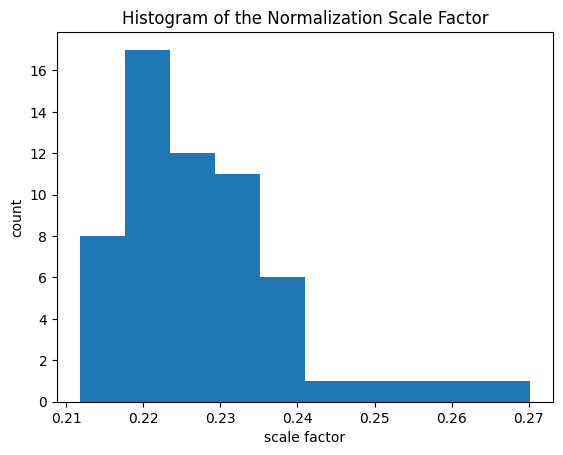

In [60]:
import matplotlib.pyplot as plt
plt.hist(cache['blocks.0.ln1.hook_scale'].flatten())
plt.title('Histogram of the Normalization Scale Factor')
plt.ylabel("count")
plt.xlabel("scale factor")


(array([ 7.,  8.,  8., 10., 13.,  7.,  3.,  2.,  0.,  1.]),
 array([0.50054097, 0.52995318, 0.55936533, 0.58877754, 0.61818975,
        0.64760196, 0.67701411, 0.70642632, 0.73583853, 0.76525068,
        0.79466289]),
 <BarContainer object of 10 artists>)

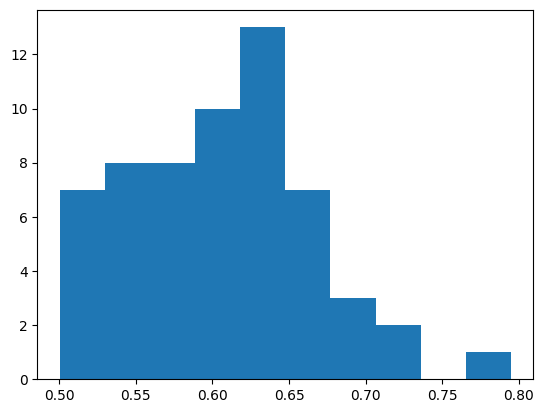

In [61]:
plt.hist(cache['ln_final.hook_scale'].flatten())


(array([1.0000e+00, 0.0000e+00, 4.0000e+00, 6.7400e+02, 1.9833e+04,
        9.5630e+03, 1.2700e+02, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-11.78080082,  -9.34030151,  -6.89980221,  -4.45930338,
         -2.01880407,   0.42169523,   2.86219454,   5.30269384,
          7.74319267,  10.18369198,  12.62419128]),
 <BarContainer object of 10 artists>)

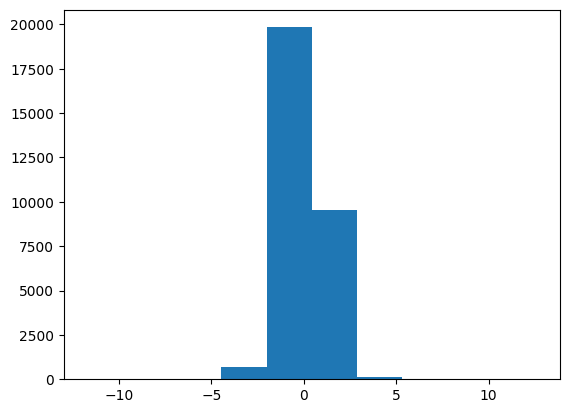

In [69]:
plt.hist(cache['blocks.0.ln1.hook_normalized'].flatten())
#plt.hist(cache['ln_final.hook_normalized'].flatten())